# 머신러닝

In [2]:
import pandas as pd

#그래프에 한글 표현하기
import  matplotlib.pyplot as plt
import  matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = "../malgun.ttf").get_name()
plt.rc("font", family = font_name)


#마이너스 표시하기
import  matplotlib as mlp
mlp.rcParams["axes.unicode_minus"]  = False

import numpy as np
import pandas  as pd
import seaborn as sns
##회귀분석
import statsmodels.api as sm
# 정규화
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import  RFE
from lightgbm import LGBMClassifier,  LGBMRegressor
from lightgbm import plot_importance, plot_metric, plot_tree
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR, SVC
import multiprocessing 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression
from scipy import stats
#사용법이 파이선과 다른 기존xgb를  파이선에 맞게 만들어 놓은 것
from  xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import RobustScaler

#변수영향도 그래프, 트리그래프 더 쉽게 그리게 해줌
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_absolute_error, mean_squared_error

# 함수정의

In [5]:
#ridge, lasso, elasticnet을 위한 alpha값 찾기 함수
def alphas_finder(model):
    alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
    for alpha in alphas:
        modeling = model(alpha=alpha)
        modeling.fit(X_train, y_train)
        print(alpha , ":" ,round(modeling.score(X_train, y_train),3)
              , round(modeling.score(X_test, y_test),3)
              ,"mae:",round(mean_absolute_error(modeling.predict(X_test), y_test),3))    


#교차검증
from sklearn.model_selection import KFold

#kfold 설정
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True,random_state=0)

#mae kfold 교차검증 함수
def mae_kfold(model):
    i = 1
    total_error = 0
    for train_index, test_index in kfold.split(X):
        x_train_fold, x_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = Y[train_index], Y[test_index]
        model_pred_fold = model.fit(x_train_fold, y_train_fold).predict(x_test_fold)
        error = mean_absolute_error(model_pred_fold, y_test_fold)
        print('Fold = {}, mae = {:.2f}'.format(i, error))
        total_error += error
        i+=1
    print('---'*10)
    print('Average Error: %s' % (total_error / n_splits))
    print('---'*10)
    
    
#변수영향도 시각화
def plot_coef(columns, coef):
    coef_df = pd.DataFrame(list(zip(columns, coef)))
    coef_df.columns=['feature', 'coef']
    coef_df = coef_df.sort_values('coef').reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.barh(np.arange(len(coef_df)), coef_df['coef'], color = "orange", alpha = 0.8)
    idx = np.arange(len(coef_df))
    ax.set_yticks(idx)
    ax.set_yticklabels(coef_df['feature'])
    fig.tight_layout()
    
    #plt.show()

# 1. 절도폭력-None scaling_ridge(alpha = 10)

In [9]:
df = pd.read_csv("1_최종데이터셋/1_절도폭력안전도.csv")

#R에서 Allsubset regression으로뽑은 변수들만 출력 :10개
#회귀분석에서 연관이 있었던 2개 변수 추가
df = df[["crm_wthr_바람","crm_clue_피해자신고","crm_clue_고소","crm_clue_현행범","vic_sx_2","vic_age_60세초과","cctv_개수",
         "배치인원_수","비상벨_개수",
        "일인가구수","기초수급_19세이하","외국인수", "score_절폭"]]

In [10]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_절폭"],test_size = 0.3, random_state=0)

In [11]:
X = np.array(df.drop('score_절폭', 1))
Y = np.array(df['score_절폭'])

In [12]:
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.33
Fold = 2, mae = 1.62
Fold = 3, mae = 1.37
Fold = 4, mae = 1.75
Fold = 5, mae = 1.53
------------------------------
Average Error: 1.521106647783995
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.52
------------------------------
Average Error: 1.5075273238352587
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.5080502639713802
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.508107044538015
------------------------------
Fold = 1, mae = 1.34
Fold = 2, mae = 1.63
Fold = 3, mae = 1.32
Fold = 4, mae = 1.74
Fold = 5, mae = 1.51
------------------------------
Average Error: 1.508112771769579
-----------------------------

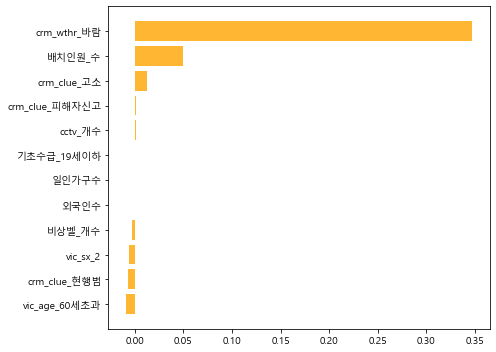

In [13]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
plot_coef(X_train.columns  , ridge.coef_)

# 2. 강도살인-robust_scaling svr(kernel = linear)

In [15]:
df = pd.read_csv("1_최종데이터셋/2_강도살인안전도.csv")
#R에서 Allsubset regression으로뽑은 변수들만 출력 : 15개 채택 
# 부동산피해 천원 이상치 너무 커서 삭제->성능오름
df = df[["crm_clue_변사체","crm_clue_자수","crm_clue_진정","crm_clue_현행범","crm_tm_저녁"
    ,"vic_sx_1","강도살인_검거수","화재_사망","화재_부상","공원_개수","자살_사망률_10만명당"
         ,"자살_연령표준화사망률_10만명당","기초수급_35_59세","기초수급_60세이상","외국인수", "score_강살"]]

In [16]:
#각 변수들을 스케일링 하는 함수

def robust_scaling(df, scale_columns):
    for col in scale_columns:
        series_med = df[col].median()
        series_per75 = np.percentile(df[col],75)
        series_per25 = np.percentile(df[col],25)
        df[col] = df[col].apply(lambda x: (x-series_med)/(series_per75-series_per25))
        
            
    return df

#변사체는 0,1,2밖에없어서 스케일링 안되므로 제외하고 함
robust_scaling(df, df.iloc[:,3:-1].columns)

,crm_clue_변사체,crm_clue_자수,crm_clue_진정,crm_clue_현행범,crm_tm_저녁,vic_sx_1,강도살인_검거수,화재_사망,화재_부상,공원_개수,자살_사망률_10만명당,자살_연령표준화사망률_10만명당,기초수급_35_59세,기초수급_60세이상,외국인수,score_강살
0,0,0,0,0.000000,2.0,0.000000,0.750,0.5,1.4,1.722222,-0.072289,0.083333,0.191860,0.100498,0.550122,79.20
1,0,0,0,0.666667,0.5,0.888889,0.875,0.0,-0.3,0.870370,0.578313,0.833333,0.191860,0.100498,1.315080,70.80
2,1,0,0,0.666667,1.0,0.222222,2.750,-0.5,0.0,0.759259,-0.024096,0.083333,0.191860,0.100498,0.871326,74.10
3,0,0,0,0.333333,0.5,-0.222222,0.875,0.5,-0.8,0.185185,-1.662651,-1.333333,0.690648,0.496633,-0.421798,75.25
4,0,0,0,-0.333333,0.0,-0.222222,0.125,-0.5,-0.9,0.000000,0.144578,-0.083333,0.690648,0.496633,-0.501924,80.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,0,0,-0.333333,-1.0,-0.666667,-0.625,-0.5,0.0,-0.611111,-0.072289,-0.166667,0.291130,0.563607,-0.165763,79.35
119,2,0,0,0.333333,-1.0,0.444444,-0.625,0.0,-0.1,-0.018519,0.915663,0.972222,0.933073,1.132582,0.068142,74.85
120,0,0,0,-0.333333,0.0,0.000000,0.000,1.0,0.7,-0.759259,-1.373494,-0.861111,-0.594276,-0.436393,0.217810,79.75
121,1,0,0,0.000000,-0.5,-0.444444,0.250,1.5,0.6,-0.777778,-0.433735,-0.138889,-0.618399,-0.503733,0.143020,75.20


In [17]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_강살"],test_size = 0.3, random_state=0)

In [18]:
X = np.array(df.drop('score_강살', 1))
Y = np.array(df['score_강살'])

In [19]:
#SVR
svr = SVR(kernel="linear")
svr.fit(X_train, y_train)

print("학습 결과 : ", svr.score(X_train, y_train))
print("테스트 결과 : ", svr.score(X_test, y_test))
print("테스트 결과 : ", mean_absolute_error(svr.predict(X_test), y_test))

학습 결과 :  0.5610673737710913
테스트 결과 :  0.4250130910570791
테스트 결과 :  1.9565649700437853


In [20]:
mae_kfold(svr)

Fold = 1, mae = 1.72
Fold = 2, mae = 2.30
Fold = 3, mae = 1.42
Fold = 4, mae = 1.82
Fold = 5, mae = 1.84
------------------------------
Average Error: 1.819326665967181
------------------------------


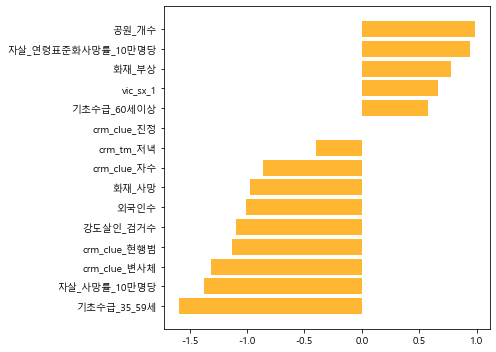

In [21]:
plot_coef(X_train.columns, np.ravel(svr.coef_) )

# 3. 교통사고-non-scaling elasticnet(alpha = 1)

In [23]:
df = pd.read_csv("1_최종데이터셋/3_교통사고안전도.csv")
#R에서 Allsubset regression으로뽑은 변수들만 출력 : 8개 
df = df[["crm_wthr_눈","crm_clue_피해자신고","vic_age_2_30대","일인가구수"
    ,"총_인구수","기초수급_19세이하","기초수급_60세이상"
         ,"외국인수", "score_교통"]]

In [24]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_교통"],test_size = 0.3, random_state=0)

In [25]:
X = np.array(df.drop('score_교통', 1))
Y = np.array(df['score_교통'])

In [26]:

for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    elastic = ElasticNet(alpha=i)
    mae_kfold(elastic)

Fold = 1, mae = 1.27
Fold = 2, mae = 1.86
Fold = 3, mae = 1.52
Fold = 4, mae = 1.34
Fold = 5, mae = 1.79
------------------------------
Average Error: 1.556202193532804
------------------------------
Fold = 1, mae = 1.22
Fold = 2, mae = 1.74
Fold = 3, mae = 1.49
Fold = 4, mae = 1.42
Fold = 5, mae = 1.78
------------------------------
Average Error: 1.5312748887786998
------------------------------
Fold = 1, mae = 1.24
Fold = 2, mae = 1.68
Fold = 3, mae = 1.50
Fold = 4, mae = 1.49
Fold = 5, mae = 1.71
------------------------------
Average Error: 1.5251810656016176
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.61
Fold = 4, mae = 1.50
Fold = 5, mae = 1.62
------------------------------
Average Error: 1.5358995111007527
------------------------------
Fold = 1, mae = 1.26
Fold = 2, mae = 1.69
Fold = 3, mae = 1.62
Fold = 4, mae = 1.50
Fold = 5, mae = 1.61
------------------------------
Average Error: 1.5378750095399216
---------------------------

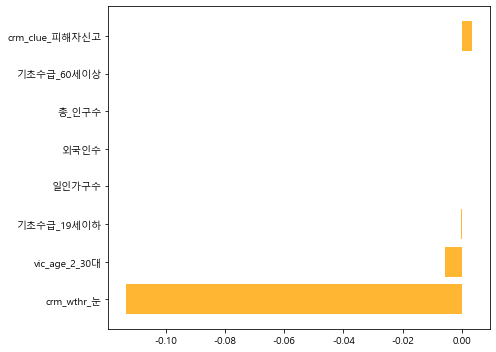

In [27]:
elastic = ElasticNet(alpha=1)
elastic.fit(X_train, y_train)
plot_coef(X_train.columns, np.ravel(elastic.coef_) )

# 4. 법질서-minmax scaling  ridge(alpha= 0.1)

In [32]:
df = pd.read_csv("1_최종데이터셋/4_법질서안전도.csv")
#R에서 Allsubset regression으로뽑은 변수들만 출력  :13개
df = df[["crm_clue_자수","crm_clue_타인신고","crm_clue_현행범","crm_clue_탐문정보","vic_sx_2","기초수급_19세이하","기초수급_20_34세",
         "crm_tm_새벽","화재_사망","cctv_개수","배치인원_수","비상벨_개수","일인가구수", "score_법질서"]]

In [33]:
#각 변수들을 스케일링 하는 함수

def minmax_scaling(df, scale_columns):
    for col in scale_columns:
        series_min = df[col].min()
        series_max = df[col].max()
        df[col] = df[col].apply(lambda x: (x-series_min)/(series_max-series_min))
        
            
    return df

minmax_scaling(df, df.columns[:-1])

,crm_clue_자수,crm_clue_타인신고,crm_clue_현행범,crm_clue_탐문정보,vic_sx_2,기초수급_19세이하,기초수급_20_34세,crm_tm_새벽,화재_사망,cctv_개수,배치인원_수,비상벨_개수,일인가구수,score_법질서
0,0.497041,1.000000,0.625576,0.626609,0.673776,0.476709,0.284368,0.942928,0.142857,0.730191,0.643392,0.002812,0.423996,67.60
1,0.236686,0.483165,0.414747,0.283262,0.380332,0.476709,0.284368,0.460298,0.071429,0.451078,0.301746,0.000562,0.216117,64.90
2,0.585799,0.500000,0.690092,0.412017,0.600711,0.476709,0.284368,0.526055,0.000000,0.688014,0.488778,0.004499,0.323532,66.10
3,0.076923,0.159933,0.177419,0.321888,0.159558,0.698292,0.354395,0.143921,0.142857,0.187316,0.119701,0.006187,0.143554,64.65
4,0.230769,0.225589,0.052995,0.278970,0.108215,0.698292,0.354395,0.090571,0.000000,0.140022,0.012469,0.006749,0.155186,69.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.035503,0.072391,0.120968,0.025751,0.034755,0.368079,0.384495,0.043424,0.000000,0.286091,0.097257,0.280652,0.179222,69.75
119,0.065089,0.375421,0.543779,0.103004,0.294234,0.580343,0.506934,0.373449,0.071429,0.691425,0.670823,1.000000,0.418713,66.30
120,0.011834,0.170034,0.266129,0.047210,0.155213,0.023831,0.042002,0.136476,0.214286,0.240813,0.246883,0.190664,0.130084,68.15
121,0.000000,0.153199,0.220046,0.072961,0.068720,0.008716,0.045678,0.081886,0.285714,0.120019,0.189526,0.023622,0.323076,66.40


In [36]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_법질서"],test_size = 0.3, random_state=0)

In [37]:
X = np.array(df.drop('score_법질서', 1))
Y = np.array(df['score_법질서'])

In [38]:
#best1, 1.89
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 2.81
Fold = 2, mae = 2.97
Fold = 3, mae = 2.64
Fold = 4, mae = 2.99
Fold = 5, mae = 3.43
------------------------------
Average Error: 2.96970096603373
------------------------------
Fold = 1, mae = 2.46
Fold = 2, mae = 2.86
Fold = 3, mae = 2.37
Fold = 4, mae = 2.61
Fold = 5, mae = 3.12
------------------------------
Average Error: 2.6835033731666047
------------------------------
Fold = 1, mae = 1.67
Fold = 2, mae = 2.37
Fold = 3, mae = 1.91
Fold = 4, mae = 1.91
Fold = 5, mae = 2.61
------------------------------
Average Error: 2.093716437342189
------------------------------
Fold = 1, mae = 1.57
Fold = 2, mae = 2.17
Fold = 3, mae = 1.88
Fold = 4, mae = 1.53
Fold = 5, mae = 2.33
------------------------------
Average Error: 1.8991734432184775
------------------------------
Fold = 1, mae = 1.69
Fold = 2, mae = 2.17
Fold = 3, mae = 1.94
Fold = 4, mae = 1.49
Fold = 5, mae = 2.29
------------------------------
Average Error: 1.9152114902388333
-----------------------------

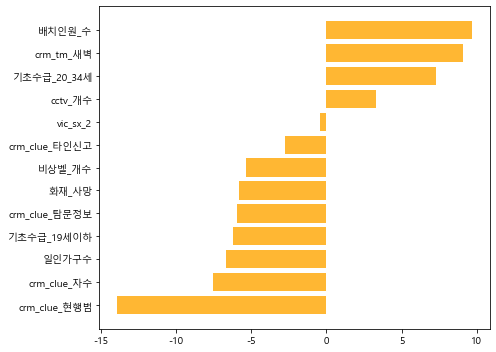

In [39]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
plot_coef(X_train.columns, np.ravel(ridge.coef_) )

# 5. 전반적-non-scaling ridge(alpha = 100)

In [40]:
df = pd.read_csv("1_최종데이터셋/5_전반적안전도.csv")
#R에서 Allsubset regression으로뽑은 변수들만 출력 :10개
df = df[["crm_wthr_흐림","crm_clue_타인신고","crm_clue_피해자신고","crm_clue_현행범","crm_tm_저녁","화재_사망","배치인원_수",
        "비상벨_개수","기초수급_19세이하","외국인수", "score_전반"]]

In [42]:
# train, test 분리
X_train, X_test, y_train, y_test  = train_test_split(df.iloc[:,:-1], df["score_전반"],test_size = 0.3, random_state=0)

In [43]:
X = np.array(df.drop('score_전반', 1))
Y = np.array(df['score_전반'])

In [44]:
#best: 1.35
for i in [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    ridge = Ridge(alpha=i)
    mae_kfold(ridge)

Fold = 1, mae = 1.42
Fold = 2, mae = 1.33
Fold = 3, mae = 1.32
Fold = 4, mae = 1.64
Fold = 5, mae = 1.05
------------------------------
Average Error: 1.3526787493256909
------------------------------
Fold = 1, mae = 1.41
Fold = 2, mae = 1.43
Fold = 3, mae = 1.32
Fold = 4, mae = 1.63
Fold = 5, mae = 1.04
------------------------------
Average Error: 1.365774281103262
------------------------------
Fold = 1, mae = 1.40
Fold = 2, mae = 1.45
Fold = 3, mae = 1.32
Fold = 4, mae = 1.63
Fold = 5, mae = 1.04
------------------------------
Average Error: 1.3678444966954344
------------------------------
Fold = 1, mae = 1.40
Fold = 2, mae = 1.45
Fold = 3, mae = 1.32
Fold = 4, mae = 1.63
Fold = 5, mae = 1.04
------------------------------
Average Error: 1.3680583309353023
------------------------------
Fold = 1, mae = 1.40
Fold = 2, mae = 1.45
Fold = 3, mae = 1.32
Fold = 4, mae = 1.63
Fold = 5, mae = 1.04
------------------------------
Average Error: 1.3680797847044022
---------------------------

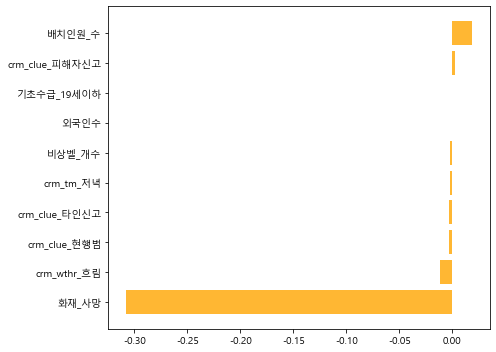

In [45]:
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
plot_coef(X_train.columns, np.ravel(ridge.coef_) )
